In [2]:
# Imports
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array,load_img,save_img
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import shutil
import keras
from keras import backend as K

import tensorflow
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.applications.vgg16 import VGG16, preprocess_input


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


Load Data 

In [4]:
current_path = os.getcwd()
training_directory_path = '/ISIC2019Dataset/ISIC_2019_Training_Input/'
training_metadata_path = '/ISIC2019Dataset/ISIC_2019_Training_Metadata.csv'
ground_truth_path = '/ISIC2019Dataset/ISIC_2019_Training_GroundTruth.csv'
test_directory_path = '/ISIC2019Dataset/ISIC_2019_Test_Input/'
test_metadata_path = '/ISIC2019Dataset/ISIC_2019_Test_Metadata.csv'

training_metadata_table = pd.read_csv(current_path + training_metadata_path)
test_metadata_table = pd.read_csv(current_path + test_metadata_path)
ground_truth_table = pd.read_csv(current_path + ground_truth_path)

**LABELS**
- **MEL** - Melanoma
- **NV** - Melanocytic nevus
- **BCC** - Basal cell carcinoma
- **AK** - Actinic keratosis
- **BKL** - Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)
- **DF** - Dermatofibroma
- **VASC** - Vascular lesion
- **SCC** - Squamous cell carcinoma
- **UNK** - None of the above


In [5]:
# ground_truth_table.drop('UNK',axis=1,inplace=True)
print(ground_truth_table.head())

          image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0


In [6]:
print(training_metadata_table.head())

          image  age_approx anatom_site_general lesion_id     sex
0  ISIC_0000000        55.0      anterior torso       NaN  female
1  ISIC_0000001        30.0      anterior torso       NaN  female
2  ISIC_0000002        60.0     upper extremity       NaN  female
3  ISIC_0000003        30.0     upper extremity       NaN    male
4  ISIC_0000004        80.0     posterior torso       NaN    male


In [7]:
print(training_metadata_table.shape)
print(ground_truth_table.shape)

(25331, 5)
(25331, 10)


In [8]:
training_metadata_table.isnull().sum()

image                     0
age_approx              437
anatom_site_general    2631
lesion_id              2084
sex                     384
dtype: int64

In [9]:
training_metadata_table['age_approx'].fillna((training_metadata_table['age_approx'].mean()), inplace=True)
training_metadata_table.dropna(subset=['anatom_site_general', 'lesion_id', 'sex'], inplace=True)
training_metadata_table.isnull().sum()

image                  0
age_approx             0
anatom_site_general    0
lesion_id              0
sex                    0
dtype: int64

Text(0.5, 1.0, 'Gender of Patient')

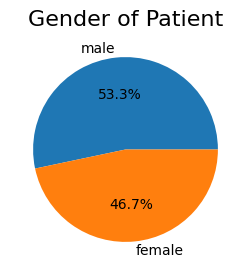

In [10]:
bar, ax = plt.subplots(figsize = (3,3))
plt.pie(training_metadata_table['sex'].value_counts(), labels = training_metadata_table['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patient', size=16)

Text(0.5, 1.0, 'Histogram of Age of Patients')

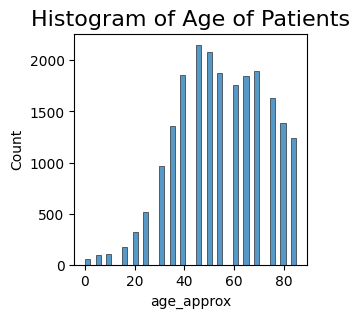

In [11]:
bar, ax = plt.subplots(figsize=(3, 3))
sns.histplot(training_metadata_table['age_approx'])
plt.title('Histogram of Age of Patients', size=16)

In [12]:
ground_truth_table.replace(['NaN', 'N/A', 'NA', 'n/a', 'n.a.', 'N#A', 'n#a', '?'], 'other', inplace=True)
missing_df =  ground_truth_table.isnull().sum().to_frame().rename(columns={0:"Total No. of Missing Values"})
missing_df["% of Missing Values"] = round((missing_df["Total No. of Missing Values"]/len( ground_truth_table))*100,2)
missing_df

,Total No. of Missing Values,% of Missing Values
image,0,0.0
MEL,0,0.0
NV,0,0.0
BCC,0,0.0
AK,0,0.0
BKL,0,0.0
DF,0,0.0
VASC,0,0.0
SCC,0,0.0
UNK,0,0.0


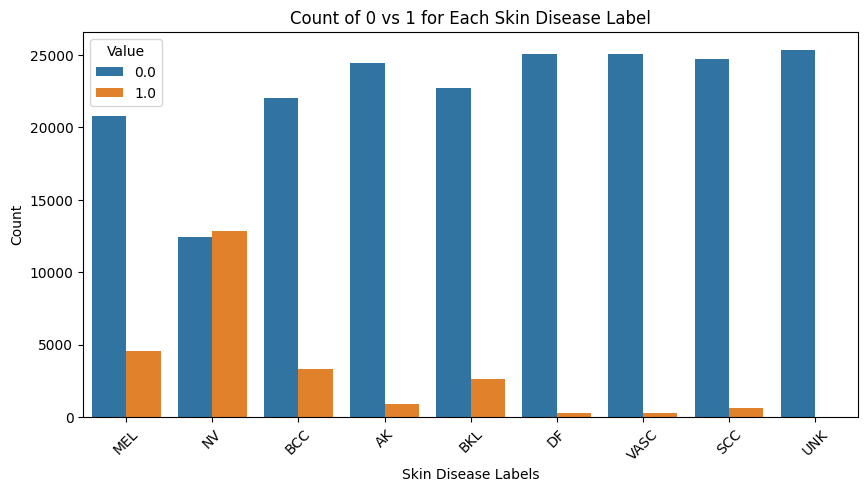

In [13]:
melted_df = pd.melt(ground_truth_table, id_vars=['image'], var_name='Label', value_name='Value')

plt.figure(figsize=(10, 5)) 
sns.countplot(x='Label', hue='Value', data=melted_df)
plt.title('Count of 0 vs 1 for Each Skin Disease Label')
plt.xlabel('Skin Disease Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.show()

In [14]:
classes=['NV','BCC','AK','BKL','DF','VASC','SCC','MEL']

ground_truth_table['label'] = ground_truth_table[classes].idxmax(axis=1)
ground_truth_table.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,label
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL


In [15]:
classes=['NV','BCC','AK','BKL','DF','VASC','SCC','MEL']

lesion_type_mapping = {lesion: idx+1 for idx, lesion in enumerate(classes)}

ground_truth_table['label'] = ground_truth_table[classes].idxmax(axis=1)

merged_data = pd.merge(training_metadata_table, ground_truth_table[['image', 'label']], on='image', how='left')

merged_data['lesion_type'] = merged_data['label']
merged_data['lesion_type_id'] = merged_data['lesion_type'].map(lesion_type_mapping)

merged_data = merged_data.drop(columns=['label'])

merged_data.head()

,image,age_approx,anatom_site_general,lesion_id,sex,lesion_type,lesion_type_id
0,ISIC_0012653_downsampled,50.0,posterior torso,MSK4_0011169,female,NV,1
1,ISIC_0012654_downsampled,30.0,lower extremity,MSK4_0011170,female,NV,1
2,ISIC_0012655_downsampled,35.0,upper extremity,MSK4_0011171,female,NV,1
3,ISIC_0012656_downsampled,45.0,posterior torso,MSK4_0011172,male,NV,1
4,ISIC_0012657_downsampled,20.0,upper extremity,MSK4_0011173,female,NV,1


Total images of NV : 12875
Total images of BCC : 3323
Total images of AK : 867
Total images of BKL : 2624
Total images of DF : 239
Total images of VASC : 253
Total images of SCC : 628
Total images of MEL : 4522


/tmp/ipykernel_2688096/2760195501.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()), palette="viridis")


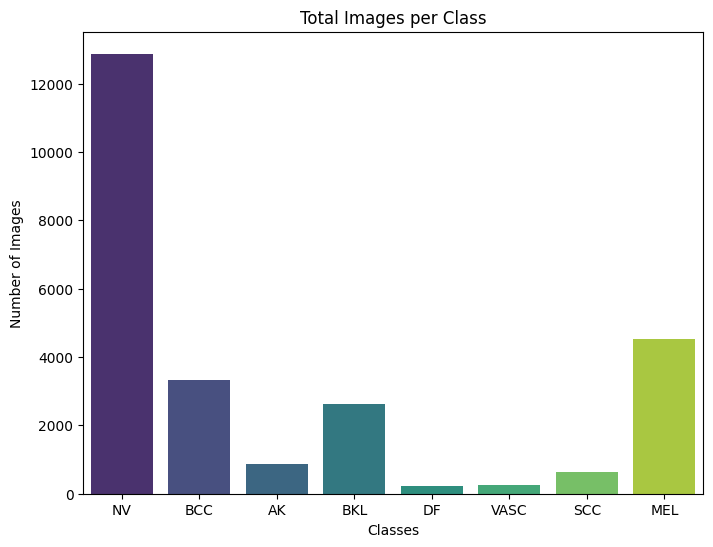

In [16]:
image_counts = {class_name: len(ground_truth_table[ground_truth_table[class_name] > 0]) for class_name in classes}

# Print the total images for each class
for class_name in classes:
    print(f"Total images of {class_name} : {image_counts[class_name]}")

plt.figure(figsize=(8, 6))
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()), palette="viridis")
plt.title('Total Images per Class')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()

In [17]:
lesion_image_count = merged_data.groupby('lesion_id').count()

lesion_single_image = lesion_image_count[lesion_image_count['image'] == 1]

lesion_single_image.reset_index(inplace=True)

lesion_single_image.head()

,lesion_id,image,age_approx,anatom_site_general,sex,lesion_type,lesion_type_id
0,BCN_0000013,1,1,1,1,1,1
1,BCN_0000020,1,1,1,1,1,1
2,BCN_0000039,1,1,1,1,1,1
3,BCN_0000053,1,1,1,1,1,1
4,BCN_0000059,1,1,1,1,1,1


In [18]:
# Identify lesion_ids that have only one image
unique_list = list(lesion_single_image['lesion_id'])

def find_duplicates(x):
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'

merged_data['duplicates'] = merged_data['lesion_id']

merged_data['duplicates'] = merged_data['duplicates'].apply(find_duplicates)

merged_data.tail()


,image,age_approx,anatom_site_general,lesion_id,sex,lesion_type,lesion_type_id,duplicates
21311,ISIC_0073247,85.0,head/neck,BCN_0003925,female,BCC,2,has_duplicates
21312,ISIC_0073248,65.0,anterior torso,BCN_0001819,male,BKL,4,has_duplicates
21313,ISIC_0073249,70.0,lower extremity,BCN_0001085,male,MEL,8,has_duplicates
21314,ISIC_0073251,55.0,palms/soles,BCN_0002083,female,NV,1,has_duplicates
21315,ISIC_0073254,50.0,upper extremity,BCN_0001079,male,BKL,4,has_duplicates


In [19]:
merged_data['duplicates'].value_counts()

duplicates
has_duplicates    15959
no_duplicates      5357
Name: count, dtype: int64

In [20]:
no_duplicate_data = merged_data[merged_data['duplicates'] == 'no_duplicates']
no_duplicate_data.shape

(5357, 8)

In [21]:
y = no_duplicate_data['lesion_type']

_, val_data = train_test_split(no_duplicate_data, test_size=0.17, random_state=101, stratify=y)

print(val_data.shape)

print(val_data['lesion_type'].value_counts())

(911, 8)
lesion_type
NV      623
BKL     107
MEL      74
BCC      60
SCC      18
AK       14
VASC      8
DF        7
Name: count, dtype: int64


In [22]:
# split into train or validation
def find_val_rows(x):
    val_list = list(val_data['image'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'


merged_data['train_or_val'] = merged_data['image']
merged_data['train_or_val'] = merged_data['train_or_val'].apply(find_val_rows)
   
train_data = merged_data[merged_data['train_or_val'] == 'train']


print(len(train_data))
print(len(val_data))

20405
911


In [23]:
print(train_data['lesion_type'].value_counts())
print(val_data['lesion_type'].value_counts())

lesion_type
NV      9128
MEL     4027
BCC     3185
BKL     2188
AK       831
SCC      604
DF       228
VASC     214
Name: count, dtype: int64
lesion_type
NV      623
BKL     107
MEL      74
BCC      60
SCC      18
AK       14
VASC      8
DF        7
Name: count, dtype: int64


In [24]:
base_dir = current_path + '/ISIC2019Dataset/ISIC_2019_Images/'
train_dir = os.path.join(base_dir, 'train_dir')
val_dir = os.path.join(base_dir, 'val_dir')

# if not os.path.exists(train_dir):
#     os.mkdir(train_dir)

# if not os.path.exists(val_dir):
#     os.mkdir(val_dir)

# for c in classes:
#     # folders inside train_dir
#     class_train_dir = os.path.join(train_dir, c)
#     if not os.path.exists(class_train_dir):
#         os.mkdir(class_train_dir)

#     # folders inside val_dir
#     class_val_dir = os.path.join(val_dir, c)
#     if not os.path.exists(class_val_dir):
#         os.mkdir(class_val_dir)

# print("Folders created successfully!")

In [25]:
train_data

,image,age_approx,anatom_site_general,lesion_id,sex,lesion_type,lesion_type_id,duplicates,train_or_val
0,ISIC_0012653_downsampled,50.0,posterior torso,MSK4_0011169,female,NV,1,no_duplicates,train
1,ISIC_0012654_downsampled,30.0,lower extremity,MSK4_0011170,female,NV,1,no_duplicates,train
2,ISIC_0012655_downsampled,35.0,upper extremity,MSK4_0011171,female,NV,1,no_duplicates,train
4,ISIC_0012657_downsampled,20.0,upper extremity,MSK4_0011173,female,NV,1,no_duplicates,train
5,ISIC_0012658_downsampled,40.0,posterior torso,MSK4_0010465,male,NV,1,no_duplicates,train
...,...,...,...,...,...,...,...,...,...
21311,ISIC_0073247,85.0,head/neck,BCN_0003925,female,BCC,2,has_duplicates,train
21312,ISIC_0073248,65.0,anterior torso,BCN_0001819,male,BKL,4,has_duplicates,train
21313,ISIC_0073249,70.0,lower extremity,BCN_0001085,male,MEL,8,has_duplicates,train
21314,ISIC_0073251,55.0,palms/soles,BCN_0002083,female,NV,1,has_duplicates,train


In [26]:
# merged_data.set_index('image', inplace=True)
# folder = os.listdir(current_path + training_directory_path)

# train_list = list(train_data['image'])
# val_list = list(val_data['image'])



# for image in train_list:
    
#     fname = image + '.jpg'
#     label = merged_data.loc[image,'lesion_type']
    
#     if fname in folder:
#         src = os.path.join(current_path + training_directory_path, fname)
#         dst = os.path.join(train_dir, label, fname)
#         print(src)
#         print(dst)
#         shutil.copyfile(src, dst)



# for image in val_list:
    
#     fname = image + '.jpg'
#     label = merged_data.loc[image,'lesion_type']
    
#     if fname in folder:
#         src = os.path.join(current_path + training_directory_path, fname)
#         dst = os.path.join(val_dir, label, fname)
#         shutil.copyfile(src, dst)


VGG16 Model

In [27]:
print("Train directory:")
for cls in classes:
    print(f"{cls}: {len(os.listdir(os.path.join(train_dir, cls)))} images")

print("\nValidation directory:")
for cls in classes:
    print(f"{cls}: {len(os.listdir(os.path.join(val_dir, cls)))} images")

Train directory:
NV: 9228 images
BCC: 9220 images
AK: 9060 images
BKL: 9202 images
DF: 8436 images
VASC: 7918 images
SCC: 8606 images
MEL: 9204 images

Validation directory:
NV: 623 images
BCC: 60 images
AK: 14 images
BKL: 107 images
DF: 7 images
VASC: 8 images
SCC: 18 images
MEL: 74 images


In [28]:
# num_aug_images_wanted = 9200  
# batch_size = 50

# for img_class in classes:
    
#     aug_dir = os.path.join(base_dir, 'aug_dir')

#     if os.path.exists(aug_dir):
#         shutil.rmtree(aug_dir)
    
#     os.mkdir(aug_dir)
#     img_dir = os.path.join(aug_dir, 'img_dir') 
#     os.mkdir(img_dir)

#     img_list = os.listdir(os.path.join(train_dir, img_class))

#     for fname in img_list:
#         src = os.path.join(train_dir, img_class, fname)
#         dst = os.path.join(img_dir, fname)
#         shutil.copyfile(src, dst)

#     path = aug_dir
#     save_path = os.path.join(train_dir, img_class)  

#     num_aug_images_wanted = 9200  
#     batch_size = 50

#     datagen = ImageDataGenerator(
#         rotation_range=180,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         zoom_range=0.1,
#         horizontal_flip=True,
#         vertical_flip=True,
#         fill_mode='nearest'
#     )

#     aug_datagen = datagen.flow_from_directory(
#         path,
#         save_to_dir=save_path,
#         save_format='jpg',
#         target_size=(224, 224),
#         batch_size=batch_size
#     )

#     num_files = len(os.listdir(img_dir))
#     num_batches = int(np.ceil((num_aug_images_wanted - num_files) / batch_size))

#     for i in range(num_batches):
#         imgs, labels = next(aug_datagen)

#     shutil.rmtree(aug_dir)

# print("Augmentation complete for all classes!")

In [29]:
# num_train_samples = len(train_data)  
# num_val_samples = len(val_data)      

# train_batch_size = 20
# val_batch_size = 20

# # VGG16 requires 224x224 image size
# image_size = 224

# # steps per epoch
# train_steps = np.ceil(num_train_samples / train_batch_size)
# val_steps = np.ceil(num_val_samples / val_batch_size)

# # data augmentation and preprocessing
# datagen = ImageDataGenerator(
#     preprocessing_function=preprocess_input  # VGG16's preprocessing function
# )

# # load training and validation batches
# train_batches = datagen.flow_from_directory(
#     train_dir,
#     target_size=(image_size, image_size),
#     batch_size=train_batch_size
# )

# valid_batches = datagen.flow_from_directory(
#     val_dir,
#     target_size=(image_size, image_size),
#     batch_size=val_batch_size
# )

# test_batches = datagen.flow_from_directory(
#     val_dir,
#     target_size=(image_size, image_size),
#     batch_size=1,
#     shuffle=False
# )

# vgg16_model = VGG16()

# vgg16_model.summary()

In [28]:
# from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
# from keras.applications import VGG16
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.metrics import categorical_accuracy
from keras.applications.mobilenet import preprocess_input
from keras.applications import MobileNet
from keras.layers import BatchNormalization
from sklearn.metrics import f1_score, recall_score, precision_score
import keras.backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# VGG16 requires 224x224 image size
image_size = 224

# Dataset sizes
num_train_samples = len(train_data)
num_val_samples = len(val_data)

# Batch sizes
train_batch_size = 20
val_batch_size = 20

# Steps per epoch
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

# Data Augmentation and preprocessing for training and validation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input 
#     rescale=1./255,
    # rotation_range=180,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # brightness_range=[0.5, 1.5],
    # zoom_range=0.6,
    # horizontal_flip=True,
    # vertical_flip=True,
    # fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
#     rescale=1./255,
    # brightness_range=[0.5, 1.5]
)

# Generate training and validation data
train_batches = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=train_batch_size,
    shuffle=True
)
valid_batches = valid_datagen.flow_from_directory(
    val_dir,
    target_size=(image_size, image_size),
    batch_size=val_batch_size
)

input_shape = (image_size, image_size, 3)
VGG_16_base_model = VGG16(include_top=False, input_shape=input_shape, weights='imagenet')
base_model = MobileNet(include_top=False, input_shape=input_shape, weights='imagenet')


for layer in base_model.layers[:-10]:
    layer.trainable = False

# Add custom layers on top of model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.35)(x)
x = BatchNormalization()(x)
predictions = Dense(8, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=[categorical_accuracy, recall_m, precision_m, f1_m])

# Define class weights to handle class imbalance
class_weights = {
    0: 1.0,  # AK
    1: 1.0,  # BCC
    2: 1.0,  # BKL
    3: 1.0,  # DF
    4: 5.0,  # MEL  # Increase sensitivity to melanoma
    5: 1.0,  # NV
    6: 1.0,  # SCC
    7: 1.0   # VASC
}

# checkpoint = ModelCheckpoint(os.path.join(current_path, 'vgg16_checkpoint.h5'), monitor='val_categorical_accuracy', verbose=1, 
#                              save_best_only=True, mode='max')
checkpoint = ModelCheckpoint(os.path.join(current_path, 'mobilenet_checkpoint3.h5'), monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')


reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=10, 
                              verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

# Train the model
history = model.fit_generator(
    train_batches,
    validation_data=valid_batches,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    epochs=30,
    class_weight=class_weights,
    callbacks=callbacks_list
)
# for i in range(5):
#     print(f'Training batch {i + 1} of 5...')
#     history = model.fit(
#     train_batches,
#     validation_data=valid_batches,
#     steps_per_epoch=train_steps,
#     validation_steps=val_steps,
#     epochs=5,
#     class_weight=class_weights,
#     callbacks=callbacks_list)
# #     model.save(os.path.join(current_path, f'vgg16_partial_trained_model_batch_{i + 1}.h5'))
#     model.save(os.path.join(current_path, f'mobilenet_partial_trained_model2_batch_{i + 1}.h5'))


# model.save(os.path.join(current_path, 'vgg16_full_model_after_training.h5'))

model.save(os.path.join(current_path, 'mobilenet_full_model_after_training3.h5'))


Found 70874 images belonging to 8 classes.
Found 911 images belonging to 8 classes.


/tmp/ipykernel_2688096/1674665573.py:126: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
1021/1021 [==============================] - ETA: 0s - loss: 3.1115 - categorical_accuracy: 0.2763 - recall_m: 0.1511 - precision_m: 0.3561 - f1_m: 0.2090
Epoch 1: val_categorical_accuracy improved from -inf to 0.63227, saving model to /home/fall2019/qnd5128/capstone/SkinLesionClassification/mobilenet_checkpoint3.h5


/home/fall2019/qnd5128/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1021/1021 [==============================] - 400s 389ms/step - loss: 3.1115 - categorical_accuracy: 0.2763 - recall_m: 0.1511 - precision_m: 0.3561 - f1_m: 0.2090 - val_loss: 1.1163 - val_categorical_accuracy: 0.6323 - val_recall_m: 0.5042 - val_precision_m: 0.7382 - val_f1_m: 0.5967 - lr: 1.0000e-05
Epoch 2/30
1021/1021 [==============================] - ETA: 0s - loss: 2.4916 - categorical_accuracy: 0.3851 - recall_m: 0.2540 - precision_m: 0.4899 - f1_m: 0.3313
Epoch 2: val_categorical_accuracy improved from 0.63227 to 0.67289, saving model to /home/fall2019/qnd5128/capstone/SkinLesionClassification/mobilenet_checkpoint3.h5
1021/1021 [==============================] - 334s 327ms/step - loss: 2.4916 - categorical_accuracy: 0.3851 - recall_m: 0.2540 - precision_m: 0.4899 - f1_m: 0.3313 - val_loss: 0.9816 - val_categorical_accuracy: 0.6729 - val_recall_m: 0.5849 - val_precision_m: 0.7640 - val_f1_m: 0.6603 - lr: 1.0000e-05
Epoch 3/30
1021/1021 [==============================] - ETA: 0s 

Epoch 16/30
1021/1021 [==============================] - ETA: 0s - loss: 1.4873 - categorical_accuracy: 0.5681 - recall_m: 0.4694 - precision_m: 0.6575 - f1_m: 0.5452
Epoch 16: val_categorical_accuracy did not improve from 0.74863
1021/1021 [==============================] - 107s 105ms/step - loss: 1.4873 - categorical_accuracy: 0.5681 - recall_m: 0.4694 - precision_m: 0.6575 - f1_m: 0.5452 - val_loss: 0.8413 - val_categorical_accuracy: 0.7036 - val_recall_m: 0.6653 - val_precision_m: 0.7372 - val_f1_m: 0.6986 - lr: 1.0000e-05
Epoch 17/30
1021/1021 [==============================] - ETA: 0s - loss: 1.4559 - categorical_accuracy: 0.5749 - recall_m: 0.4767 - precision_m: 0.6582 - f1_m: 0.5505
Epoch 17: val_categorical_accuracy improved from 0.74863 to 0.75082, saving model to /home/fall2019/qnd5128/capstone/SkinLesionClassification/mobilenet_checkpoint3.h5
1021/1021 [==============================] - 111s 109ms/step - loss: 1.4559 - categorical_accuracy: 0.5749 - recall_m: 0.4767 - preci

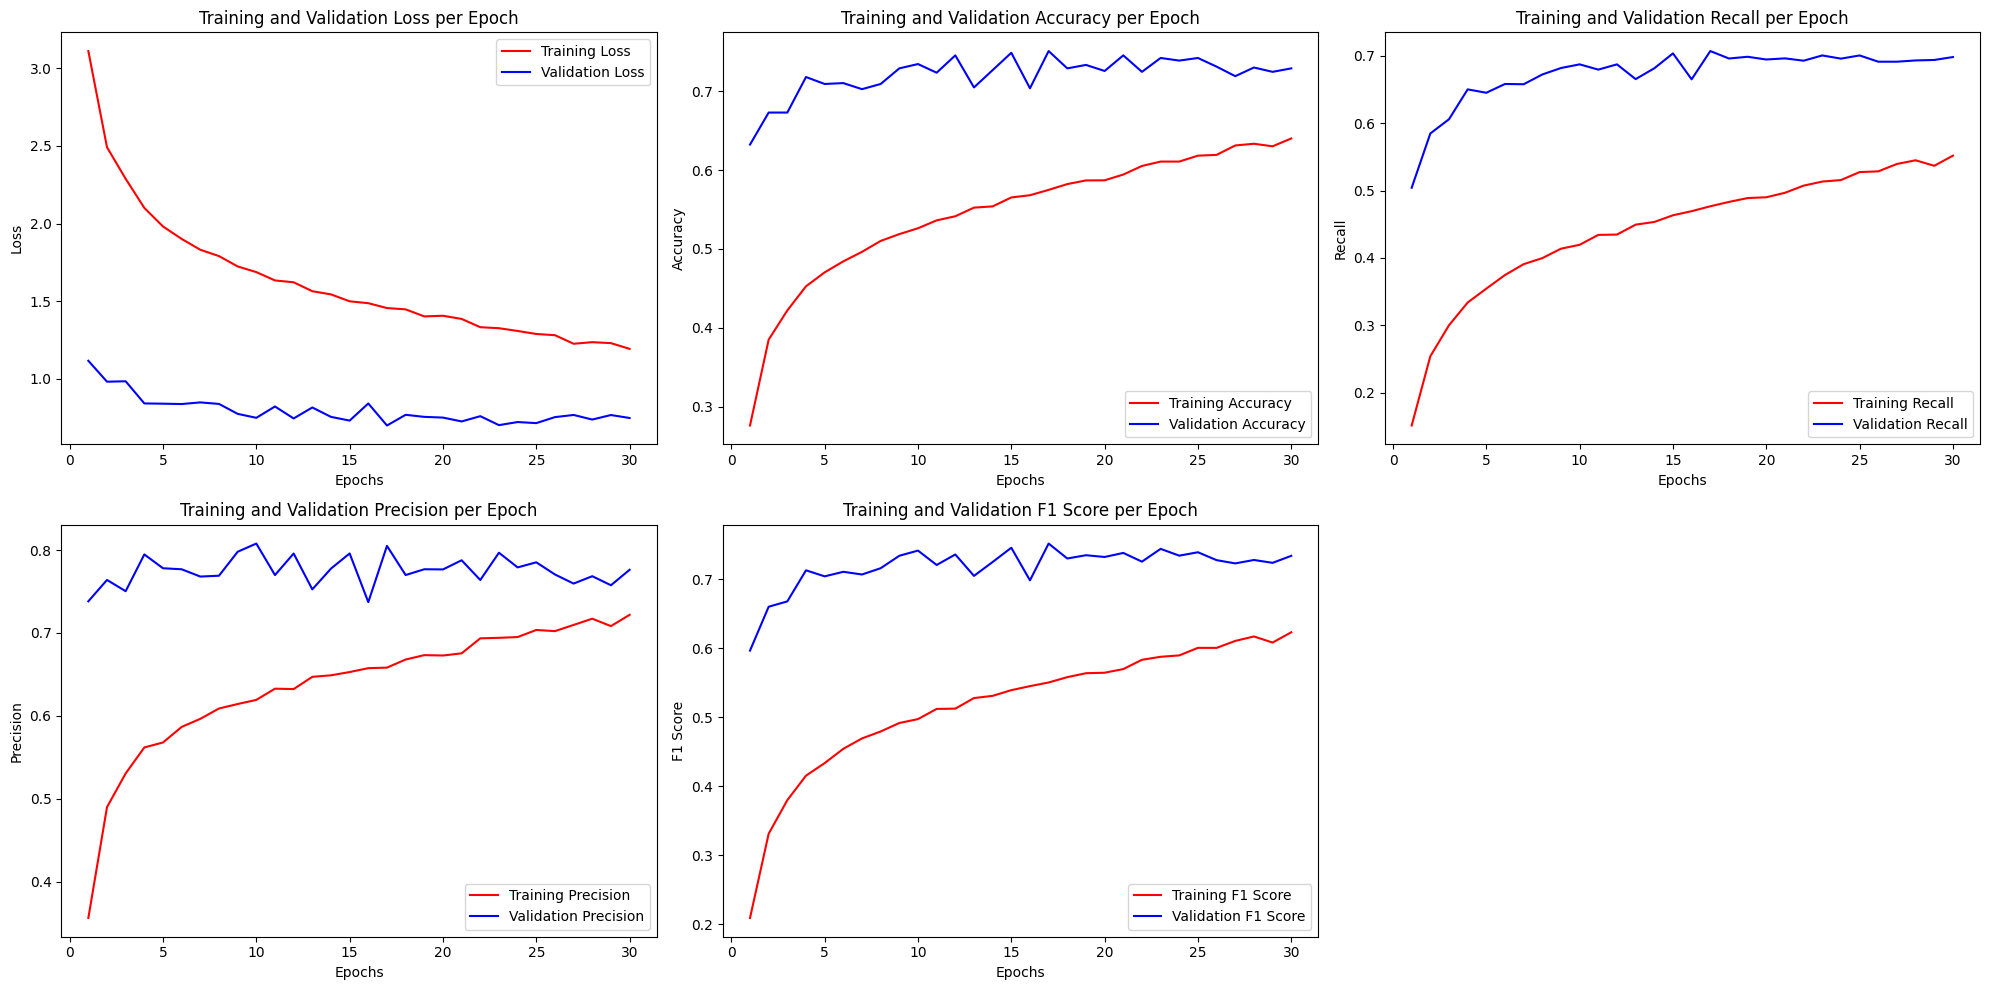

In [29]:
# Extract metrics from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
train_recall = history.history['recall_m']
val_recall = history.history['val_recall_m']
train_precision = history.history['precision_m']
val_precision = history.history['val_precision_m']
train_f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']

epochs = range(1, len(train_loss) + 1)

# Plot and save the metrics
plt.figure(figsize=(20, 10))

# Plot Loss
plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(current_path, 'training_validation_loss.png'))

# Plot Accuracy
plt.subplot(2, 3, 2)
plt.plot(epochs, train_acc, 'r-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(os.path.join(current_path, 'training_validation_accuracy.png'))

# Plot Recall
plt.subplot(2, 3, 3)
plt.plot(epochs, train_recall, 'r-', label='Training Recall')
plt.plot(epochs, val_recall, 'b-', label='Validation Recall')
plt.title('Training and Validation Recall per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.savefig(os.path.join(current_path, 'training_validation_recall.png'))

# Plot Precision
plt.subplot(2, 3, 4)
plt.plot(epochs, train_precision, 'r-', label='Training Precision')
plt.plot(epochs, val_precision, 'b-', label='Validation Precision')
plt.title('Training and Validation Precision per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.savefig(os.path.join(current_path, 'training_validation_precision.png'))

# Plot F1 Score
plt.subplot(2, 3, 5)
plt.plot(epochs, train_f1, 'r-', label='Training F1 Score')
plt.plot(epochs, val_f1, 'b-', label='Validation F1 Score')
plt.title('Training and Validation F1 Score per Epoch')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.savefig(os.path.join(current_path, 'training_validation_f1_score.png'))

plt.tight_layout()
plt.savefig(os.path.join(current_path, 'all_metrics_plots.png'))
plt.show()

In [33]:

predictions = model.predict_generator(valid_batches, steps=len(val_data), verbose=1)


/tmp/ipykernel_2688096/731684894.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(valid_batches, steps=len(val_data), verbose=1)


911/911 [==============================] - 8s 8ms/step


Confusion matrix, without normalization
[[  0   2   1   0   3   8   0   0]
 [  0   2   8   1  15  34   0   0]
 [  2   4   3   0  36  62   0   0]
 [  0   0   0   0   0   7   0   0]
 [  2   5   5   0  16  46   0   0]
 [  3  32  32   3 146 399   4   4]
 [  1   2   1   0   6   8   0   0]
 [  0   0   0   0   2   6   0   0]]


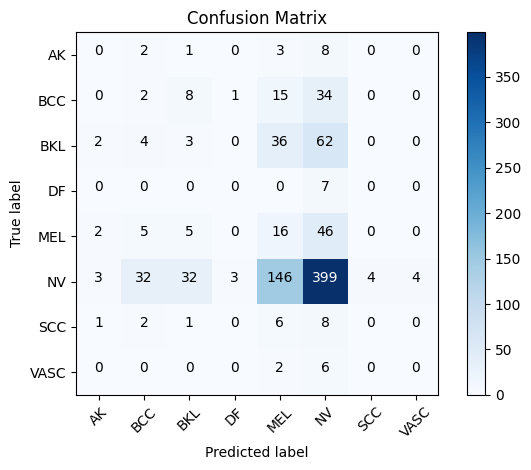

In [40]:
from sklearn import metrics
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

test_labels = valid_batches.classes
cm_plot_labels = ['AK', 'BCC', 'BKL', 'DF', 'MEL','NV', 'SCC', 'VASC']
cm = metrics.confusion_matrix(test_labels, predictions.argmax(axis=1))

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [42]:
from sklearn.metrics import classification_report

y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = valid_batches.classes

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

          AK       0.00      0.00      0.00        14
         BCC       0.04      0.03      0.04        60
         BKL       0.06      0.03      0.04       107
          DF       0.00      0.00      0.00         7
         MEL       0.07      0.22      0.11        74
          NV       0.70      0.64      0.67       623
         SCC       0.00      0.00      0.00        18
        VASC       0.00      0.00      0.00         8

    accuracy                           0.46       911
   macro avg       0.11      0.11      0.11       911
weighted avg       0.49      0.46      0.47       911

